In [22]:

import ccxt
from crypto_data_fetcher.ftx import FtxFetcher
import talib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
import numba

ImportError: Numba needs NumPy 1.20 or less

In [2]:
ftx = ccxt.ftx()
fetcher = FtxFetcher(ccxt_client=ftx)

df = fetcher.fetch_ohlcv(
    market='BTC-PERP', # 市場のシンボルを指定。この場合は https://ftx.com/trade/BTC-PERP を取得
    interval_sec=5 * 60, # 足の間隔を秒単位で指定。この場合は5分足
)

display(df)

,op,hi,lo,cl,volume
timestamp,,,,,
2019-07-20 12:35:00+00:00,10564.25,10573.25,10560.50,10564.25,6.365293e+05
2019-07-20 12:40:00+00:00,10564.25,10567.00,10550.25,10556.50,1.207911e+06
2019-07-20 12:45:00+00:00,10556.50,10568.00,10525.50,10540.25,2.228462e+06
2019-07-20 12:50:00+00:00,10540.25,10551.75,10529.50,10541.00,2.662661e+06
2019-07-20 12:55:00+00:00,10542.25,10545.00,10528.25,10539.50,1.063855e+06
...,...,...,...,...,...
2021-10-19 13:40:00+00:00,62887.00,63000.00,62211.00,62667.00,1.129969e+08
2021-10-19 13:45:00+00:00,62667.00,62900.00,62601.00,62836.00,4.943574e+07
2021-10-19 13:50:00+00:00,62836.00,63180.00,62685.00,62836.00,7.711539e+07


In [3]:
df.to_pickle('df_ohlcv.pkl')

In [4]:
def calc_features(df):
    open = df['op']
    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    
    orig_columns = df.columns

    print('calc talib overlap')
    hilo = (df['hi'] + df['lo']) / 2
    df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] -= hilo
    df['BBANDS_middleband'] -= hilo
    df['BBANDS_lowerband'] -= hilo
    df['DEMA'] = talib.DEMA(close, timeperiod=30) - hilo
    df['EMA'] = talib.EMA(close, timeperiod=30) - hilo
    df['HT_TRENDLINE'] = talib.HT_TRENDLINE(close) - hilo
    df['KAMA'] = talib.KAMA(close, timeperiod=30) - hilo
    df['MA'] = talib.MA(close, timeperiod=30, matype=0) - hilo
    df['MIDPOINT'] = talib.MIDPOINT(close, timeperiod=14) - hilo
    df['SMA'] = talib.SMA(close, timeperiod=30) - hilo
    df['T3'] = talib.T3(close, timeperiod=5, vfactor=0) - hilo
    df['TEMA'] = talib.TEMA(close, timeperiod=30) - hilo
    df['TRIMA'] = talib.TRIMA(close, timeperiod=30) - hilo
    df['WMA'] = talib.WMA(close, timeperiod=30) - hilo

    print('calc talib momentum')
    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
    df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
    df['BOP'] = talib.BOP(open, high, low, close)
    df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
    df['DX'] = talib.DX(high, low, close, timeperiod=14)
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    # skip MACDEXT MACDFIX たぶん同じなので
    df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
    df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
    df['MOM'] = talib.MOM(close, timeperiod=10)
    df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(close, timeperiod=30)
    df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

    print('calc talib volume')
    df['AD'] = talib.AD(high, low, close, volume)
    df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    df['OBV'] = talib.OBV(close, volume)

    print('calc talib vola')
    df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
    df['NATR'] = talib.NATR(high, low, close, timeperiod=14)
    df['TRANGE'] = talib.TRANGE(high, low, close)

    print('calc talib cycle')
    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

    print('calc talib stats')
    df['BETA'] = talib.BETA(high, low, timeperiod=5)
    df['CORREL'] = talib.CORREL(high, low, timeperiod=30)
    df['LINEARREG'] = talib.LINEARREG(close, timeperiod=14) - close
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14)
    df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1)

    return df

df = pd.read_pickle('df_ohlcv.pkl')
df = df.dropna()
df = df.reset_index()
df = df[df['timestamp'] < pd.to_datetime('2021-01-01 00:00:00Z')] # テスト期間を残せるように少し前で設定
df = calc_features(df)

df = df.set_index('timestamp')
display(df)
df.to_pickle('df_features.pkl')

calc talib overlap
calc talib momentum
calc talib volume
calc talib vola
calc talib cycle
calc talib stats


,op,hi,lo,cl,volume,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,...,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-07-20 12:35:00+00:00,10564.25,10573.25,10560.50,10564.25,6.365293e+05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-20 12:40:00+00:00,10564.25,10567.00,10550.25,10556.50,1.207911e+06,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-20 12:45:00+00:00,10556.50,10568.00,10525.50,10540.25,2.228462e+06,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-20 12:50:00+00:00,10540.25,10551.75,10529.50,10541.00,2.662661e+06,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-20 12:55:00+00:00,10542.25,10545.00,10528.25,10539.50,1.063855e+06,32.015600,11.675,-8.665600,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,10.170300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 23:35:00+00:00,29010.00,29033.00,28957.00,29020.00,5.158382e+06,134.349727,56.400,-21.549727,117.708041,69.229032,...,-0.681007,0.036253,0,0.734472,0.814366,13.242857,-84.330257,144.185714,-10.072527,38.974864
2020-12-31 23:40:00+00:00,29020.00,29023.50,28848.50,28848.50,6.726253e+06,214.240981,61.100,-92.040981,146.642295,114.311030,...,-0.653066,0.073706,0,-0.200726,0.835766,124.442857,-86.486959,336.200000,-16.289011,76.570490
2020-12-31 23:45:00+00:00,28842.00,28995.50,28816.00,28992.50,1.473222e+07,215.812621,77.250,-61.312621,167.587548,140.831286,...,-0.504478,0.253813,0,0.006370,0.869861,-31.442857,-86.505537,181.442857,-16.375824,69.281311


In [5]:
features = sorted([
    'ADX',
    'ADXR',
    'APO',
    'AROON_aroondown',
    'AROON_aroonup',
    'AROONOSC',
    'CCI',
    'DX',
    'MACD_macd',
    'MACD_macdsignal',
    'MACD_macdhist',
    'MFI',
#     'MINUS_DI',
#     'MINUS_DM',
    'MOM',
#     'PLUS_DI',
#     'PLUS_DM',
    'RSI',
    'STOCH_slowk',
    'STOCH_slowd',
    'STOCHF_fastk',
    'STOCHRSI_fastd',
    'ULTOSC',
    'WILLR',
    'ADOSC',
#     'NATR',
    'HT_DCPERIOD',
    'HT_DCPHASE',
    'HT_PHASOR_inphase',
    'HT_PHASOR_quadrature',
    'HT_TRENDMODE',
    'BETA',
    'LINEARREG',
    'LINEARREG_ANGLE',
    'LINEARREG_INTERCEPT',
    'LINEARREG_SLOPE',
    'STDDEV',
    'BBANDS_upperband',
    'BBANDS_middleband',
    'BBANDS_lowerband',
    'DEMA',
    'EMA',
    'HT_TRENDLINE',
    'KAMA',
    'MA',
    'MIDPOINT',
    'T3',
    'TEMA',
    'TRIMA',
    'WMA',
])

dfは特徴量が入ったDataFrame
featuresは使う特徴量カラム名配列
重要度表示。重要度が高いものは汎化性能に悪影響を与える可能性がある


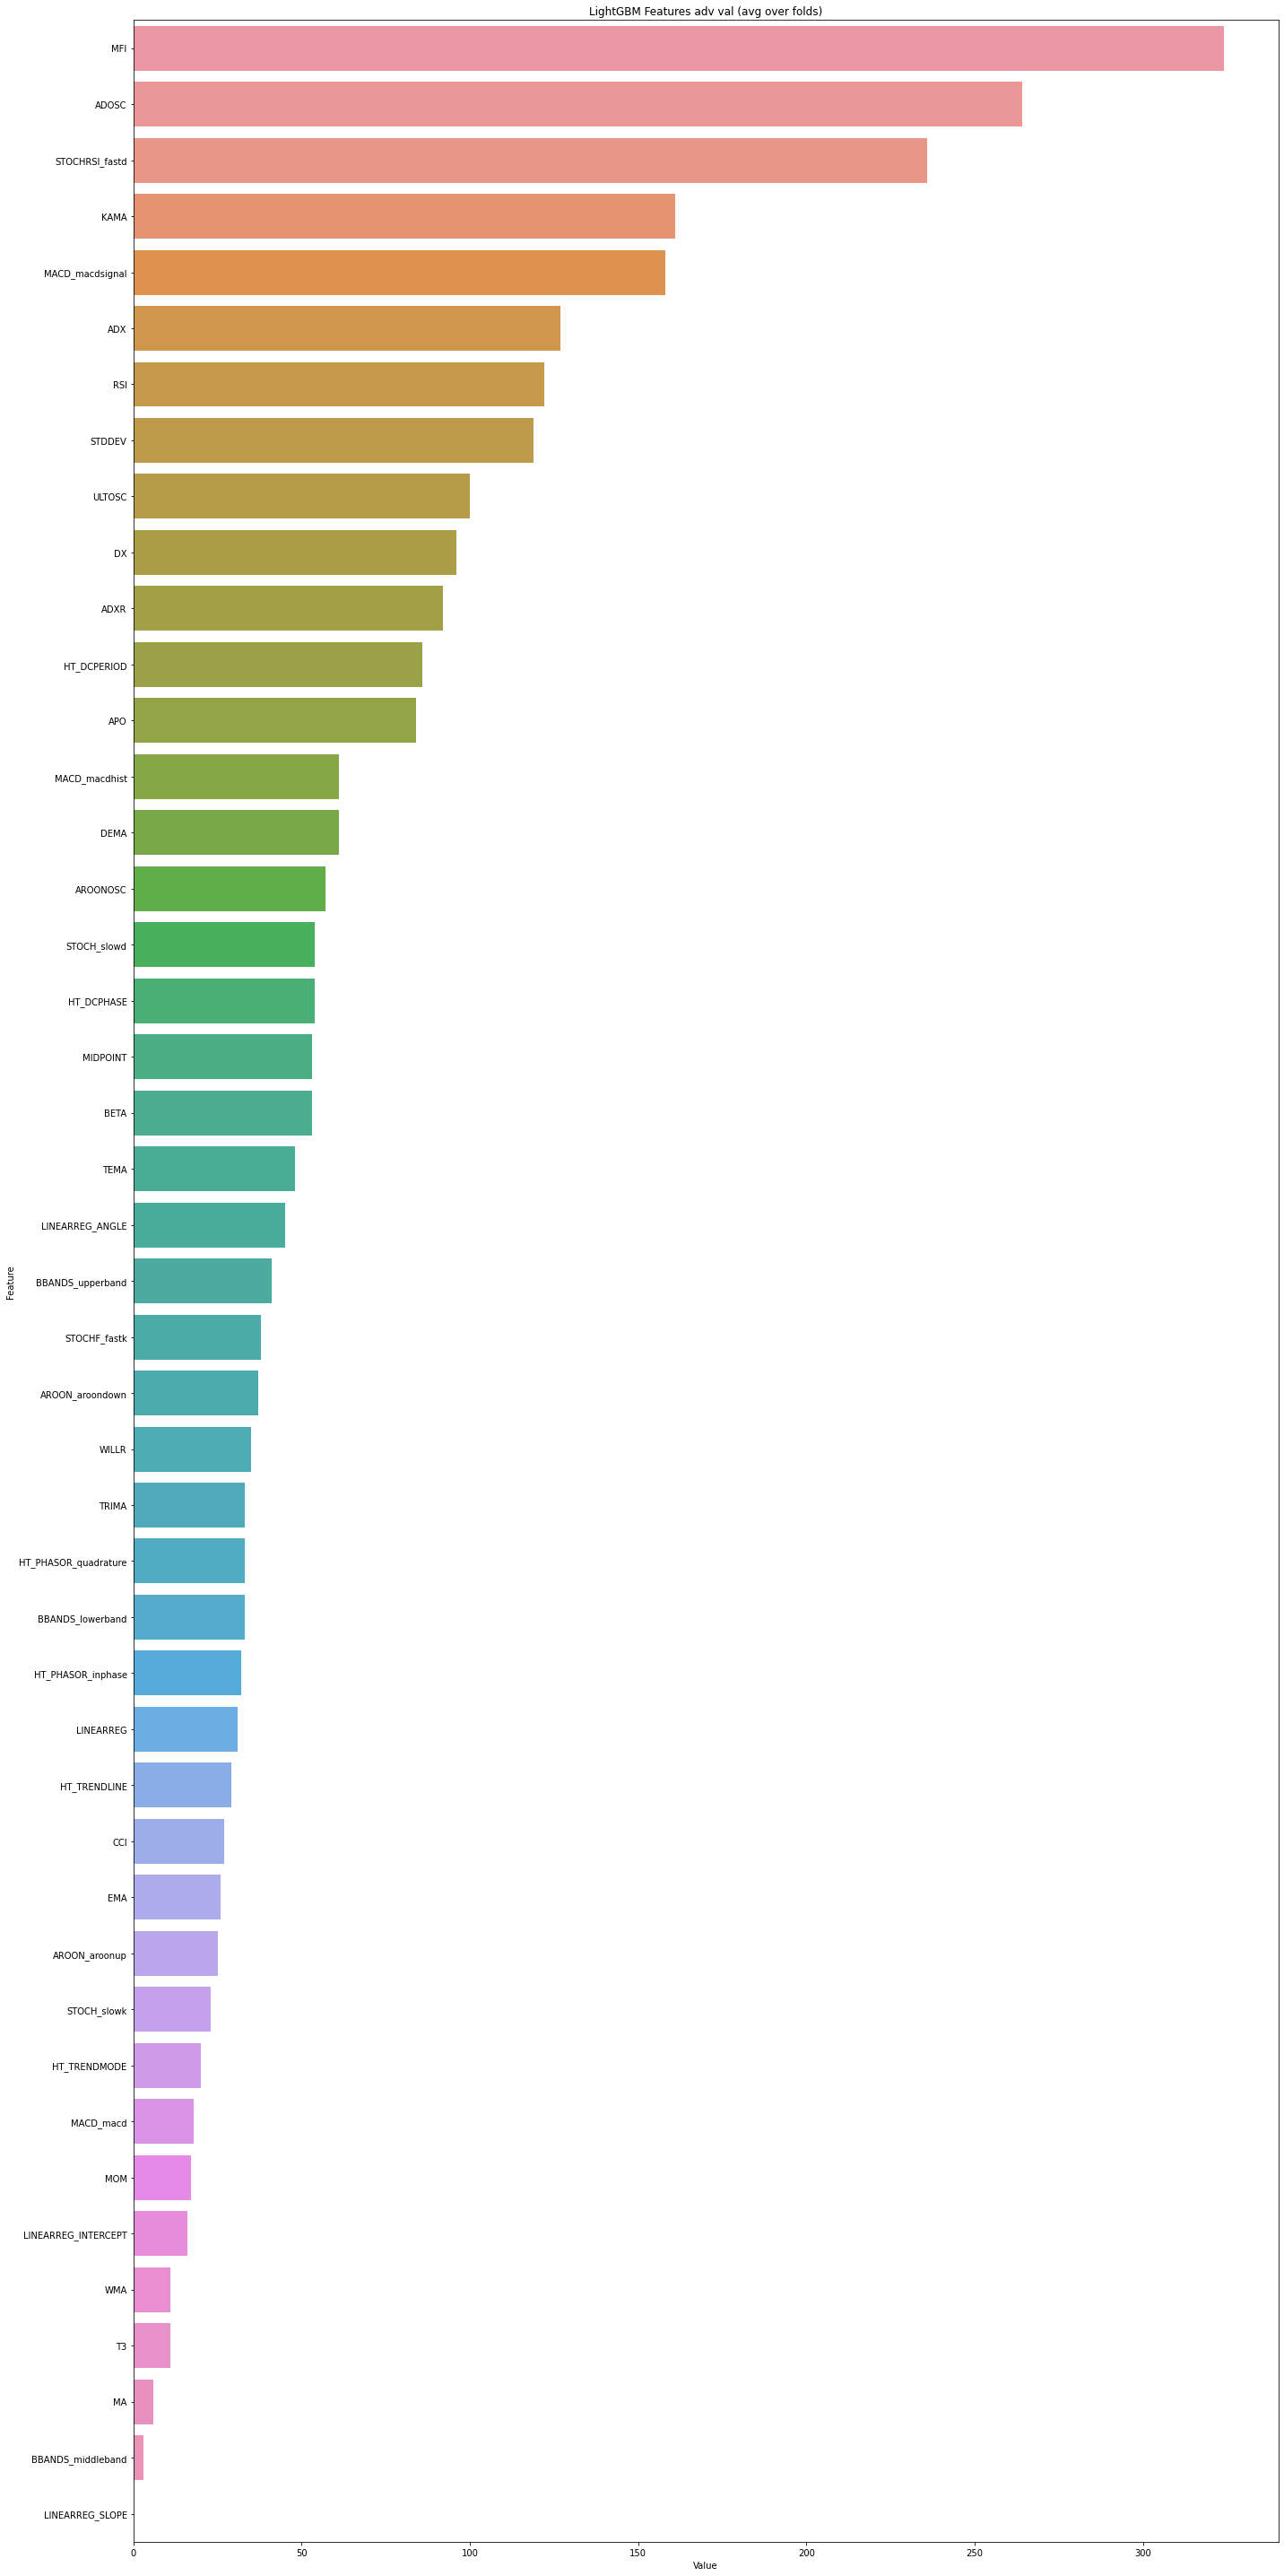

スコア計算。スコアが高いと汎化性能が悪い可能性ある (目安は0.3以下)


NameError: name 'KFold' is not defined

In [17]:
df = pd.read_pickle('df_features.pkl')

print('dfは特徴量が入ったDataFrame')
print('featuresは使う特徴量カラム名配列')

print('重要度表示。重要度が高いものは汎化性能に悪影響を与える可能性がある')
model = lgb.LGBMRegressor(n_jobs=-1, random_state=1)
model.fit(df[features], np.arange(df.shape[0]))
lgbm_adv_importance = model.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, features)), columns=['Value','Feature'])
plt.figure(figsize=(20, 40))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features adv val (avg over folds)')
plt.tight_layout()
plt.show()

print('スコア計算。スコアが高いと汎化性能が悪い可能性ある (目安は0.3以下)')
cv = KFold(n_splits=2, shuffle=True, random_state=0)
scores = cross_val_score(model, df[features], np.arange(df.shape[0]), scoring='r2', cv=cv)
print('scores', scores)
print('score mean, std', np.mean(scores), np.std(scores))

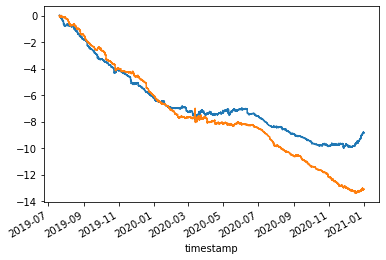

In [23]:
# @numba.njit
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                break
    return y

df = pd.read_pickle('df_features.pkl')

# FTX BTC-PERPだとpipsが時期で変化するので(0.25〜1くらい)、
# 約定シミュレーションは小さい単位でやって、指値計算は大きい単位でやる
min_pips = 0.001
max_pips = 1

# limit_price_dist = max_pips
limit_price_dist = df['ATR'] * 0.5
limit_price_dist = np.maximum(1, (limit_price_dist / max_pips).round().fillna(1)) * max_pips

df['buy_price'] = df['cl'] - limit_price_dist
df['sell_price'] = df['cl'] + limit_price_dist

df['buy_fep'] = calc_force_entry_price(
    entry_price=df['buy_price'].values,
    lo=df['lo'].values,
    pips=min_pips,
)

# calc_force_entry_priceは入力をマイナスにすれば売りに使える
df['sell_fep'] = -calc_force_entry_price(
    entry_price=-df['sell_price'].values,
    lo=-df['hi'].values, # 売りのときは高値
    pips=min_pips,
)

horizon = 1
fee = 0.0

df['y_buy'] = np.where(
    (df['buy_price'] / min_pips).round() > (df['lo'].shift(-1) / min_pips).round(),
    df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
    0
)
df['y_sell'] = np.where(
    (df['sell_price'] / min_pips).round() < (df['hi'].shift(-1) / min_pips).round(),
    -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
    0
)

# バックテストで利用
df['buy_cost'] = np.where(
    (df['buy_price'] / min_pips).round() > (df['lo'].shift(-1) / min_pips).round(),
    df['buy_price'] / df['cl'] - 1 + fee,
    0
)
df['sell_cost'] = np.where(
    (df['sell_price'] / min_pips).round() < (df['hi'].shift(-1) / min_pips).round(),
    -(df['sell_price'] / df['cl'] - 1) + fee,
    0
)

df['y_buy'].cumsum().plot()
df['y_sell'].cumsum().plot()
plt.show()

df.to_pickle('df_y.pkl')